In [1]:
import pandas as pd
from freesurfer_stats import CorticalParcellationStats
import glob
import re
import itertools
import numpy as np
import pyls
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
import pickle
from sklearn import preprocessing
from scipy.stats import zscore
from nilearn import input_data
from nilearn import plotting
import pingouin as pg

/opt/miniconda3/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
/opt/miniconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
sns.set_context("notebook", font_scale=1.7)
sns.set_style("whitegrid")

## Carga datos volúmenes

In [3]:
all_volumes_file = 'data/all_volumes.csv'
all_volumes = pd.read_csv(all_volumes_file)
all_volumes.drop(columns=all_volumes.columns[0], axis=1, inplace=True)
#all_volumes.columns.to_list()

# Selección de estructuras, no se inlcluye el 5to ventrículo
columns = list(range(0,15)) + list(range(21,54)) + list(range(61,467))
selected_values = all_volumes.iloc[:,columns]

# Cambio nombre grupo
selected_values.rename(columns={'grupo': 'group'}, inplace=True)

# Selección prisma 1
selected_values = selected_values.loc[selected_values['project'].isin(['prisma1','controles'])]
#selected_values

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_74755/1209840877.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_values.rename(columns={'grupo': 'group'}, inplace=True)


In [4]:
# Conteo datos iniciales
selected_values.groupby('group').describe()

Brain Segmentation Volume                                         \
                          count          mean            std       min   
group                                                                    
CTR                        40.0  1.095219e+06  114375.642017  919318.0   
EQF                        59.0  1.116020e+06  103986.285611  901796.0   
TAB                        87.0  1.058379e+06  115520.861944  850640.0   

                                                   \
             25%        50%        75%        max   
group                                               
CTR    1036581.5  1074693.0  1137592.5  1497849.0   
EQF    1041860.5  1111795.0  1180947.0  1397788.0   
TAB     973184.5  1049510.0  1141247.5  1324372.0   

      Brain Segmentation Volume Without Ventricles                ...  \
                                             count          mean  ...   
group                                                             ...   
CTR                                           40.0  1.076981e+06  ...   
EQF                                           59.0  1.089898e+06  ...   
TAB                                           87.0  1.034507e+06  ...   

      17Networks_RH_TempPar_9         17Networks_RH_TempPar_10              \
                          75%     max                    count        mean   
group                                                                        
CTR                    765.75  1491.0                     40.0  902.375000   
EQF                    800.50  1164.0                     59.0  867.508475   
TAB                    735.00  1467.0                     87.0  854.494253   

                                                         
              std    min     25%    50%     75%     max  
group                                                    
CTR    184.436451  549.0  807.25  904.0   971.5  1375.0  
EQF    183.123980  510.0  743.00  867.0  1010.0  1422.0  
TAB    208.654709  319.0  721.00  830.0   962.0  1452.0  

[3 rows x 3608 columns]

In [5]:
# Selección sujetos chequeo freesurfer
check_file = 'data/ConsolidadoRatings.xlsx'
check_data = pd.read_excel(check_file,'ALL')
suj_to_remove = check_data[check_data['Rating'] == 'FaIL'].Codigo

selected_values = selected_values.set_index('subject')
selected_values.drop(index=suj_to_remove,inplace=True)
selected_values = selected_values.reset_index(drop=False)
selected_values.groupby('group').describe()

Brain Segmentation Volume                                         \
                          count          mean            std       min   
group                                                                    
CTR                        32.0  1.105633e+06  113994.378721  923026.0   
EQF                        39.0  1.121151e+06   94271.957433  969343.0   
TAB                        66.0  1.067572e+06  119389.639898  850640.0   

                                                    \
             25%        50%         75%        max   
group                                                
CTR    1042351.5  1083722.5  1137592.50  1497849.0   
EQF    1052149.0  1111795.0  1178443.50  1397788.0   
TAB     974377.5  1051649.0  1154686.75  1324372.0   

      Brain Segmentation Volume Without Ventricles                ...  \
                                             count          mean  ...   
group                                                             ...   
CTR                                           32.0  1.087699e+06  ...   
EQF                                           39.0  1.095700e+06  ...   
TAB                                           66.0  1.043146e+06  ...   

      17Networks_RH_TempPar_9         17Networks_RH_TempPar_10              \
                          75%     max                    count        mean   
group                                                                        
CTR                    765.75  1491.0                     32.0  887.968750   
EQF                    805.50  1164.0                     39.0  868.128205   
TAB                    760.50  1467.0                     66.0  860.696970   

                                                        
              std    min     25%    50%    75%     max  
group                                                   
CTR    184.815424  549.0  786.50  896.0  971.5  1375.0  
EQF    187.454581  510.0  756.00  841.0  985.0  1422.0  
TAB    171.937643  549.0  735.75  841.0  967.0  1333.0  

[3 rows x 3608 columns]

## Normalización por volumen intracraneal

In [6]:
selected_values.iloc[:,3:] = selected_values.iloc[:,3:].div(selected_values["Estimated Total Intracranial Volume"], axis=0)
#selected_values

In [7]:
all_data = selected_values
# Remover columna de ETIV
all_data = all_data.drop(['Estimated Total Intracranial Volume'],axis=1)
#all_data

## Carga de datos clínicos

In [8]:
clinical_file = 'data/BFCN_t1_cov.xlsx'
clinical_data = pd.read_excel(clinical_file)
clinical_data.loc[clinical_data.subject.str.contains('CTRL'), 'project'] = 'controles'
# Selección de variables
clinical_data.drop(columns=['group','columna1','dim3','dim4','id_prisma'],inplace=True)
#clinical_data

## Merge both files

In [9]:
# Unión archivos volúmenes e información clínica
clinical_image_df= pd.merge(all_data, clinical_data, how='left', on=['subject', 'project'])
clinical_image_df.groupby('group').describe()

Brain Segmentation Volume                                          \
                          count      mean       std       min       25%   
group                                                                     
CTR                        32.0  0.831769  0.036950  0.777593  0.804141   
EQF                        39.0  0.792793  0.028862  0.735780  0.776152   
TAB                        66.0  0.795577  0.033800  0.698524  0.773953   

                                     \
            50%       75%       max   
group                                 
CTR    0.826415  0.847811  0.920915   
EQF    0.793155  0.812336  0.855939   
TAB    0.795456  0.812809  0.899731   

      Brain Segmentation Volume Without Ventricles            ...  \
                                             count      mean  ...   
group                                                         ...   
CTR                                           32.0  0.818394  ...   
EQF                                           39.0  0.774998  ...   
TAB                                           66.0  0.777574  ...   

      psy_mccb_cpt      psy_cpt_pun_t                                     \
               75%  max         count       mean        std   min    25%   
group                                                                      
CTR            NaN  NaN           0.0        NaN        NaN   NaN    NaN   
EQF          2.375  3.5          22.0  33.090909  11.575463  19.0  21.25   
TAB            NaN  NaN           0.0        NaN        NaN   NaN    NaN   

                          
        50%    75%   max  
group                     
CTR     NaN    NaN   NaN  
EQF    33.0  41.75  58.0  
TAB     NaN    NaN   NaN  

[3 rows x 4576 columns]

In [10]:
#Remove data for TAB and diagnosis 2
clinical_image_df.drop(clinical_image_df.index[clinical_image_df['diagnosis']=='Bipolar Affective Disorder 2'],inplace=True)
clinical_image_df.groupby('group').describe()

Brain Segmentation Volume                                          \
                          count      mean       std       min       25%   
group                                                                     
CTR                        32.0  0.831769  0.036950  0.777593  0.804141   
EQF                        39.0  0.792793  0.028862  0.735780  0.776152   
TAB                        59.0  0.793093  0.034260  0.698524  0.772738   

                                     \
            50%       75%       max   
group                                 
CTR    0.826415  0.847811  0.920915   
EQF    0.793155  0.812336  0.855939   
TAB    0.791251  0.809184  0.899731   

      Brain Segmentation Volume Without Ventricles            ...  \
                                             count      mean  ...   
group                                                         ...   
CTR                                           32.0  0.818394  ...   
EQF                                           39.0  0.774998  ...   
TAB                                           59.0  0.774679  ...   

      psy_mccb_cpt      psy_cpt_pun_t                                     \
               75%  max         count       mean        std   min    25%   
group                                                                      
CTR            NaN  NaN           0.0        NaN        NaN   NaN    NaN   
EQF          2.375  3.5          22.0  33.090909  11.575463  19.0  21.25   
TAB            NaN  NaN           0.0        NaN        NaN   NaN    NaN   

                          
        50%    75%   max  
group                     
CTR     NaN    NaN   NaN  
EQF    33.0  41.75  58.0  
TAB     NaN    NaN   NaN  

[3 rows x 4576 columns]

In [11]:
clinical_image_df.head()

subject group    project  Brain Segmentation Volume  \
0  CTRL028   CTR  controles                   0.829100   
1  CTRL035   CTR  controles                   0.860477   
2  CTRL032   CTR  controles                   0.806800   
3  CTRL027   CTR  controles                   0.847668   
4  CTRL026   CTR  controles                   0.802878   

   Brain Segmentation Volume Without Ventricles  \
0                                      0.813654   
1                                      0.852060   
2                                      0.791695   
3                                      0.838854   
4                                      0.787556   

   Volume of ventricles and choroid plexus  \
0                                 0.013098   
1                                 0.006345   
2                                 0.013007   
3                                 0.007049   
4                                 0.012946   

   Left hemisphere cortical gray matter volume  \
0                                     0.179406   
1                                     0.183381   
2                                     0.172058   
3                                     0.169443   
4                                     0.174586   

   Right hemisphere cortical gray matter volume  \
0                                      0.177787   
1                                      0.183885   
2                                      0.172280   
3                                      0.171519   
4                                      0.175982   

   Total cortical gray matter volume  \
0                           0.357193   
1                           0.367266   
2                           0.344339   
3                           0.340963   
4                           0.350568   

   Left hemisphere cerebral white matter volume  ...  psy_lns_pun_t  \
0                                      0.166577  ...            NaN   
1                                      0.174142  ...            NaN   
2                                      0.154804  ...            NaN   
3                                      0.171085  ...            NaN   
4                                      0.154230  ...            NaN   

   psy_cls_lns  psy_mccb_mazes  psy_mazes_pun_t  psy_cls_mazes  \
0          NaN             NaN              NaN            NaN   
1          NaN             NaN              NaN            NaN   
2          NaN             NaN              NaN            NaN   
3          NaN             NaN              NaN            NaN   
4          NaN             NaN              NaN            NaN   

   psy_mccb_fluency  psy_fluency_pun_t  psy_cls_fluency  psy_mccb_cpt  \
0               NaN                NaN              NaN           NaN   
1               NaN                NaN              NaN           NaN   
2               NaN                NaN              NaN           NaN   
3               NaN                NaN              NaN           NaN   
4               NaN                NaN              NaN           NaN   

   psy_cpt_pun_t  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  

[5 rows x 624 columns]

## Normalización de los datos

In [12]:
# Normalización z-score por fila (sujeto) para datos de volumen 3 a 454
clinical_image_z = clinical_image_df
clinical_image_z.iloc[:,3:453] = clinical_image_z.iloc[:,3:453].apply(zscore, axis=1) 
clinical_image_z.groupby('group').describe()

Brain Segmentation Volume                                             \
                          count       mean       std        min        25%   
group                                                                        
CTR                        32.0  11.199784  0.078086  11.056882  11.140956   
EQF                        39.0  11.299996  0.094658  11.099391  11.224342   
TAB                        59.0  11.292360  0.092118  11.109363  11.226153   

                                        \
             50%        75%        max   
group                                    
CTR    11.200273  11.240380  11.376816   
EQF    11.317701  11.372395  11.495431   
TAB    11.263923  11.353474  11.525020   

      Brain Segmentation Volume Without Ventricles             ...  \
                                             count       mean  ...   
group                                                          ...   
CTR                                           32.0  11.015651  ...   
EQF                                           39.0  11.040882  ...   
TAB                                           59.0  11.023837  ...   

      psy_mccb_cpt      psy_cpt_pun_t                                     \
               75%  max         count       mean        std   min    25%   
group                                                                      
CTR            NaN  NaN           0.0        NaN        NaN   NaN    NaN   
EQF          2.375  3.5          22.0  33.090909  11.575463  19.0  21.25   
TAB            NaN  NaN           0.0        NaN        NaN   NaN    NaN   

                          
        50%    75%   max  
group                     
CTR     NaN    NaN   NaN  
EQF    33.0  41.75  58.0  
TAB     NaN    NaN   NaN  

[3 rows x 4576 columns]

In [13]:
#clinical_image_z.iloc[:,453:].columns.to_list()

In [14]:
# Selección variables clínicas
list_regression = ['age','sex','education_level','etiv',
                   'antipsychotic_use','antidepressant_use','moodstabiliser_use']
list_norm = ['age','sex','education_level','etiv']

In [15]:
# Eliminación datos nan
clinical_image_z_na = clinical_image_z.dropna(subset = list_regression)
clinical_image_z_na.reset_index(drop= True, inplace=True)
clinical_image_z_na.groupby('group').describe()

Brain Segmentation Volume                                             \
                          count       mean       std        min        25%   
group                                                                        
CTR                        32.0  11.199784  0.078086  11.056882  11.140956   
EQF                        35.0  11.302707  0.098346  11.099391  11.224342   
TAB                        57.0  11.294381  0.093039  11.109363  11.226448   

                                        \
             50%        75%        max   
group                                    
CTR    11.200273  11.240380  11.376816   
EQF    11.317793  11.377805  11.495431   
TAB    11.273862  11.355903  11.525020   

      Brain Segmentation Volume Without Ventricles             ...  \
                                             count       mean  ...   
group                                                          ...   
CTR                                           32.0  11.015651  ...   
EQF                                           35.0  11.040489  ...   
TAB                                           57.0  11.023106  ...   

      psy_mccb_cpt      psy_cpt_pun_t                                      \
               75%  max         count   mean        std   min   25%   50%   
group                                                                       
CTR            NaN  NaN           0.0    NaN        NaN   NaN   NaN   NaN   
EQF          2.425  3.5          20.0  34.35  11.379922  19.0  24.0  35.0   
TAB            NaN  NaN           0.0    NaN        NaN   NaN   NaN   NaN   

                    
         75%   max  
group               
CTR      NaN   NaN  
EQF    42.25  58.0  
TAB      NaN   NaN  

[3 rows x 4576 columns]

In [16]:
# Normalización covariables por columna
clinical_image_z_na[list_norm] = clinical_image_z_na[list_norm].apply(zscore, axis=0)

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_74755/660603168.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_image_z_na[list_norm] = clinical_image_z_na[list_norm].apply(zscore, axis=0)


## Regresión lineal múltiple

In [17]:
vol_cols = clinical_image_z_na.iloc[:,3:453].columns.to_list()
residuals = pd.DataFrame()

for col in vol_cols:
    lm = pg.linear_regression(clinical_image_z_na[list_regression]
                              ,clinical_image_z_na[col])
    
    residuals[col] = lm.residuals_


/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_74755/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_74755/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_74755/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_74755/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_74755/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_74755/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_74755/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_74755/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_74755/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_74755/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_74755/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_74755/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_74755/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_74755/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_74755/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_74755/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_74755/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_74755/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_74755/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_74755/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_74755/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_74755/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_74755/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_74755/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

In [18]:
# Formación nuevo data frame
clinical_image_z_na.iloc[:,3:453] = residuals.values

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_74755/1488685466.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_image_z_na.iloc[:,3:453] = residuals.values


## PLS BEHAVIORAL

In [19]:
clinical_image_z.iloc[:,453:].columns.to_list()

['is_paisa',
 'diagnosis',
 'age',
 'sex',
 'marital_state',
 'children ',
 'occupation',
 'education_level',
 'thyriod/hormonal_disease',
 'epilepsy',
 't-t',
 'other_diagnosis',
 'what other diagnosis',
 'extension_exams',
 'neuroimaging_date ',
 'neuroimaging_results',
 'use_psychiatric_medications',
 'type_medication',
 'medications_dose',
 'antipsychotic_use',
 'antidepressant_use',
 'moodstabiliser_use',
 'antipsychotic_drugs',
 'other_psychotropic_drugs',
 'other_medication',
 'acb_score',
 'cpz',
 ' tecar',
 'somatisation ',
 'hsp',
 'duration_illness',
 'ep_dep',
 'age_onset_majordepression',
 'active_psychosis',
 'age_onset_psico',
 'major_depression_psychosis',
 'ep_man',
 'mania_psychosis ',
 'age_onset_dysthymicdisorder',
 'age_onset_cyclothymicdisorder',
 'mixed_episodes',
 'mixed_psychosis',
 'alcohol_abuse',
 'age_onset_alcohol_abuse',
 'years_alcohol_abuse',
 'spa_abuse',
 'age_onset_spa',
 'years_spa',
 'psychotic_symptoms ',
 'delusional_disorder',
 'age_onset_delusi

In [24]:
# Selección variables
# Variables clínicas que se encuentran para TAB y EQF
y_list = ['acb_score','hsp','duration_illness','years_alcohol_abuse', 'years_spa',
          'eeag_worst_moment_last_episode','eeag_last_month','psychotic_symptoms ']

In [25]:
# Eliminación datos nan
clinical_image_z_na = clinical_image_z.dropna(subset = y_list)
clinical_image_z_na.reset_index(drop= True, inplace=True)
clinical_image_z_na.groupby('group').describe()

Brain Segmentation Volume                                             \
                          count       mean       std        min        25%   
group                                                                        
EQF                        24.0  11.278403  0.095724  11.099391  11.204224   
TAB                        40.0  11.296544  0.094574  11.109363  11.235914   

                                        \
             50%        75%        max   
group                                    
EQF    11.266427  11.340530  11.449698   
TAB    11.268445  11.354292  11.525020   

      Brain Segmentation Volume Without Ventricles             ...  \
                                             count       mean  ...   
group                                                          ...   
EQF                                           24.0  11.044504  ...   
TAB                                           40.0  11.020354  ...   

      psy_mccb_cpt      psy_cpt_pun_t                                          \
               75%  max         count       mean        std   min   25%   50%   
group                                                                           
EQF           2.45  3.5          17.0  32.705882  12.061119  19.0  19.0  33.0   
TAB            NaN  NaN           0.0        NaN        NaN   NaN   NaN   NaN   

                   
        75%   max  
group              
EQF    42.0  58.0  
TAB     NaN   NaN  

[2 rows x 4576 columns]

In [26]:
# Normalización covariables por columna
clinical_image_z_na[y_list] = clinical_image_z_na[y_list].apply(zscore, axis=0)

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_74755/3512445329.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_image_z_na[y_list] = clinical_image_z_na[y_list].apply(zscore, axis=0)


In [27]:
all_data_sorted = clinical_image_z_na.sort_values('group', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

count_groups = all_data_sorted.groupby(['group']).count()
groups_dict = count_groups['subject'].to_dict()

list_len = list(groups_dict.values())
groups = list(groups_dict.keys())
groups_dict

{'EQF': 24, 'TAB': 40}

In [28]:
# Matriz X: datos de volúmenes
X_brain = all_data_sorted.iloc[:,3:453].values
if np.any(np.isnan(X_brain)):
    print('ok')
if np.any(np.isinf(X_brain)):
    print('ok')

In [29]:
Y_beha = all_data_sorted[y_list].values
if np.any(np.isnan(Y_beha)):
    print('ok')
if np.any(np.isinf(Y_beha)):
    print('ok')

In [30]:
pls = pyls.behavioral_pls(X_brain, Y_beha, groups=list_len, seed=42, n_proc='max')

Running permutations:   0%|                                   | 0/5000 | 00:00<?/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running permutations:   2%|5                             | 96/5000 | 00:00<00:10/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  10%|##8                          | 484/5000 | 00:01<00:11/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  11%|###                          | 527/5000 | 00:01<00:10/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  11%|###3                         | 574/5000 | 00:01<00:10/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  12%|###5                         | 619/5000 | 00:01<00:10/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  24%|######6                     | 1182/5000 | 00:02<00:08/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  25%|######8                     | 1228/5000 | 00:02<00:08/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running permutations:  25%|#######1                    | 1274/5000 | 00:02<00:08/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  26%|#######3                    | 1320/5000 | 00:02<00:08/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running permutations:  28%|#######9                    | 1411/5000 | 00:03<00:08/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running permutations:  30%|########4                   | 1503/5000 | 00:03<00:07/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running permutations:  32%|########9                   | 1596/5000 | 00:03<00:07/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  49%|#############7              | 2459/5000 | 00:05<00:07/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  54%|###############1            | 2702/5000 | 00:06<00:05/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  56%|###############6            | 2799/5000 | 00:06<00:05/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  61%|#################1          | 3063/5000 | 00:07<00:04/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  66%|##################3         | 3276/5000 | 00:07<00:04/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  75%|####################9       | 3741/5000 | 00:09<00:05/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  76%|#####################2      | 3787/5000 | 00:09<00:04/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  77%|#####################4      | 3831/5000 | 00:09<00:03/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  78%|#####################7      | 3875/5000 | 00:09<00:03/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  79%|######################2     | 3967/5000 | 00:09<00:02/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  80%|######################4     | 4014/5000 | 00:09<00:02/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  81%|######################7     | 4061/5000 | 00:09<00:02/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  82%|######################9     | 4107/5000 | 00:09<00:02/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  83%|#######################2    | 4152/5000 | 00:10<00:01/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  85%|#######################7    | 4243/5000 | 00:10<00:01/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  86%|########################    | 4288/5000 | 00:10<00:01/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running permutations:  87%|########################2   | 4334/5000 | 00:10<00:01/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  88%|########################5   | 4380/5000 | 00:10<00:01/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running permutations:  89%|########################7   | 4426/5000 | 00:10<00:01/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  89%|#########################   | 4472/5000 | 00:10<00:01/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running permutations:  90%|#########################3  | 4518/5000 | 00:10<00:01/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  91%|#########################5  | 4563/5000 | 00:10<00:00/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  93%|##########################  | 4653/5000 | 00:11<00:00/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:   1%|4                               | 71/5000 | 00:01<01:44/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:   2%|6                              | 103/5000 | 00:02<01:42/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:   2%|7                              | 122/5000 | 00:02<01:47/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:   3%|8                              | 142/5000 | 00:03<01:44/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   3%|9                              | 159/5000 | 00:03<01:56/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:   4%|#1                             | 193/5000 | 00:04<01:41/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:   5%|#4                             | 230/5000 | 00:05<01:48/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   5%|#5                             | 245/5000 | 00:05<02:25/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:   6%|#7                             | 278/5000 | 00:06<02:06/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:   6%|#8                             | 294/5000 | 00:06<02:16/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   6%|#9                             | 309/5000 | 00:07<01:40/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:   7%|##                             | 330/5000 | 00:07<01:35/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   7%|##1                            | 345/5000 | 00:07<01:23/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:   7%|##2                            | 362/5000 | 00:08<02:11/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   8%|##3                            | 377/5000 | 00:08<01:37/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  10%|###                            | 495/5000 | 00:11<01:56/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  10%|###1                           | 511/5000 | 00:11<01:46/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  11%|###3                           | 542/5000 | 00:12<01:22/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  11%|###4                           | 559/5000 | 00:12<01:55/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  12%|###5                           | 575/5000 | 00:13<02:08/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  12%|###7                           | 611/5000 | 00:13<01:28/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  13%|###8                           | 626/5000 | 00:14<01:45/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  13%|###9                           | 644/5000 | 00:14<01:39/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  14%|####3                          | 696/5000 | 00:15<02:01/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  14%|####4                          | 713/5000 | 00:16<01:54/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  15%|####7                          | 761/5000 | 00:17<01:41/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  16%|#####                          | 810/5000 | 00:19<02:31/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  17%|#####1                         | 826/5000 | 00:19<02:31/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  17%|#####3                         | 857/5000 | 00:20<01:59/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  17%|#####4                         | 874/5000 | 00:21<01:37/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  18%|#####5                         | 891/5000 | 00:21<01:55/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  18%|#####6                         | 907/5000 | 00:22<01:51/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  18%|#####7                         | 922/5000 | 00:22<02:14/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  19%|#####8                         | 940/5000 | 00:23<02:11/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  19%|#####9                         | 958/5000 | 00:23<01:56/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  20%|######                        | 1009/5000 | 00:25<01:37/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  22%|######5                       | 1094/5000 | 00:27<01:49/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  22%|######6                       | 1113/5000 | 00:27<01:25/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  23%|######7                       | 1129/5000 | 00:27<01:47/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  23%|######8                       | 1145/5000 | 00:28<01:18/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  24%|#######                       | 1179/5000 | 00:28<01:17/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  24%|#######1                      | 1198/5000 | 00:29<01:25/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  24%|#######2                      | 1216/5000 | 00:29<01:34/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  25%|#######4                      | 1247/5000 | 00:30<01:31/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  26%|#######8                      | 1306/5000 | 00:32<01:18/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  26%|#######9                      | 1321/5000 | 00:32<01:14/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  27%|########2                     | 1373/5000 | 00:33<01:31/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  28%|########3                     | 1390/5000 | 00:33<01:25/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  28%|########4                     | 1407/5000 | 00:34<01:41/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  28%|########5                     | 1425/5000 | 00:34<01:24/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  29%|########6                     | 1443/5000 | 00:34<00:54/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  29%|########7                     | 1462/5000 | 00:35<00:46/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  30%|########8                     | 1479/5000 | 00:35<00:50/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  31%|#########1                    | 1527/5000 | 00:36<00:52/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  31%|#########2                    | 1546/5000 | 00:36<01:09/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  31%|#########3                    | 1563/5000 | 00:37<01:47/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  32%|#########4                    | 1582/5000 | 00:37<01:03/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  33%|#########8                    | 1634/5000 | 00:38<00:57/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  33%|#########9                    | 1655/5000 | 00:38<01:03/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  33%|##########                    | 1671/5000 | 00:39<00:55/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  34%|##########1                   | 1687/5000 | 00:39<00:59/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  34%|##########3                   | 1722/5000 | 00:39<00:57/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  35%|##########5                   | 1757/5000 | 00:40<01:07/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  36%|##########8                   | 1806/5000 | 00:41<01:13/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  37%|##########9                   | 1827/5000 | 00:42<01:03/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  37%|###########                   | 1844/5000 | 00:42<00:55/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  37%|###########1                  | 1860/5000 | 00:42<00:53/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  38%|###########3                  | 1895/5000 | 00:43<01:07/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  38%|###########4                  | 1913/5000 | 00:43<01:14/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  39%|###########5                  | 1931/5000 | 00:44<01:22/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  40%|###########8                  | 1982/5000 | 00:45<01:01/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  40%|############                  | 2013/5000 | 00:46<01:13/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  41%|############3                 | 2063/5000 | 00:47<01:02/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  42%|############6                 | 2115/5000 | 00:48<00:47/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  43%|############7                 | 2133/5000 | 00:48<01:09/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  43%|############9                 | 2150/5000 | 00:49<01:11/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  44%|#############1                | 2188/5000 | 00:50<01:06/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  46%|#############8                | 2305/5000 | 00:51<00:40/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  47%|##############                | 2340/5000 | 00:52<00:48/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  47%|##############1               | 2357/5000 | 00:52<00:40/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  47%|##############2               | 2374/5000 | 00:53<00:42/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  48%|##############3               | 2391/5000 | 00:53<00:36/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  48%|##############4               | 2408/5000 | 00:53<00:34/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  51%|###############1              | 2527/5000 | 00:55<01:06/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  51%|###############2              | 2545/5000 | 00:56<00:52/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  51%|###############3              | 2560/5000 | 00:56<01:14/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  52%|###############4              | 2576/5000 | 00:57<01:13/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  52%|###############6              | 2607/5000 | 00:57<00:51/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  52%|###############7              | 2624/5000 | 00:58<00:42/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  53%|###############8              | 2640/5000 | 00:58<00:39/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  54%|################1             | 2688/5000 | 00:59<00:52/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  55%|################6             | 2773/5000 | 01:01<00:56/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  56%|################7             | 2789/5000 | 01:01<00:41/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  56%|################8             | 2806/5000 | 01:02<00:43/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  57%|#################             | 2839/5000 | 01:03<00:59/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  58%|#################3            | 2891/5000 | 01:03<00:33/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  59%|#################6            | 2943/5000 | 01:05<00:47/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  59%|#################7            | 2964/5000 | 01:05<00:40/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  61%|##################3           | 3063/5000 | 01:07<00:40/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  62%|##################4           | 3079/5000 | 01:07<00:34/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  62%|##################5           | 3095/5000 | 01:08<00:30/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  63%|##################8           | 3143/5000 | 01:09<00:34/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  64%|###################           | 3176/5000 | 01:09<00:41/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  64%|###################2          | 3210/5000 | 01:10<00:50/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  64%|###################3          | 3225/5000 | 01:10<00:42/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  65%|###################4          | 3242/5000 | 01:11<00:40/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  65%|###################5          | 3259/5000 | 01:11<00:37/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  65%|###################6          | 3274/5000 | 01:12<00:55/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  66%|###################7          | 3292/5000 | 01:12<00:47/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  66%|###################8          | 3309/5000 | 01:13<00:37/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  66%|###################9          | 3324/5000 | 01:13<00:45/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  67%|####################          | 3339/5000 | 01:13<00:48/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  67%|####################1         | 3356/5000 | 01:14<00:36/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  69%|####################6         | 3437/5000 | 01:16<00:30/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  70%|####################9         | 3490/5000 | 01:17<00:33/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  71%|#####################2        | 3537/5000 | 01:18<00:32/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  71%|#####################3        | 3552/5000 | 01:18<00:36/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  71%|#####################4        | 3568/5000 | 01:19<00:35/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  72%|#####################5        | 3584/5000 | 01:19<00:31/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  72%|#####################5        | 3600/5000 | 01:20<00:32/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  72%|#####################7        | 3620/5000 | 01:20<00:25/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  73%|#####################8        | 3635/5000 | 01:20<00:27/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  73%|######################        | 3669/5000 | 01:21<00:25/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  75%|######################4       | 3735/5000 | 01:22<00:24/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  75%|######################6       | 3767/5000 | 01:23<00:29/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  76%|######################8       | 3816/5000 | 01:24<00:20/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  77%|#######################       | 3837/5000 | 01:24<00:19/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  77%|#######################1      | 3852/5000 | 01:24<00:22/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  79%|#######################8      | 3968/5000 | 01:27<00:21/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  80%|#######################9      | 3986/5000 | 01:28<00:25/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  80%|########################      | 4002/5000 | 01:28<00:32/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  80%|########################1     | 4020/5000 | 01:29<00:28/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  81%|########################2     | 4036/5000 | 01:29<00:25/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  81%|########################3     | 4053/5000 | 01:29<00:25/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  82%|########################4     | 4083/5000 | 01:30<00:25/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  82%|########################5     | 4098/5000 | 01:31<00:38/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  83%|########################7     | 4132/5000 | 01:32<00:21/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  83%|########################8     | 4148/5000 | 01:32<00:25/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  84%|#########################1    | 4185/5000 | 01:33<00:19/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  86%|#########################8    | 4302/5000 | 01:35<00:12/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  87%|##########################1   | 4350/5000 | 01:36<00:17/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  87%|##########################1   | 4365/5000 | 01:37<00:17/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  88%|##########################4   | 4400/5000 | 01:38<00:20/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  88%|##########################4   | 4414/5000 | 01:38<00:15/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  89%|##########################5   | 4431/5000 | 01:39<00:13/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  89%|##########################6   | 4447/5000 | 01:39<00:15/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  89%|##########################7   | 4464/5000 | 01:39<00:11/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  90%|##########################8   | 4480/5000 | 01:40<00:13/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  90%|##########################9   | 4495/5000 | 01:40<00:13/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  90%|###########################   | 4511/5000 | 01:41<00:13/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  91%|###########################3  | 4561/5000 | 01:42<00:10/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  92%|###########################4  | 4576/5000 | 01:42<00:10/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  92%|###########################5  | 4592/5000 | 01:43<00:09/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  92%|###########################6  | 4607/5000 | 01:43<00:09/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  93%|###########################8  | 4641/5000 | 01:44<00:08/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  93%|###########################9  | 4658/5000 | 01:44<00:08/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  94%|############################1 | 4693/5000 | 01:45<00:05/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  94%|############################2 | 4709/5000 | 01:45<00:05/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  95%|############################4 | 4744/5000 | 01:46<00:04/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  95%|############################5 | 4759/5000 | 01:46<00:03/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  96%|############################8 | 4808/5000 | 01:47<00:04/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  96%|############################9 | 4824/5000 | 01:48<00:03/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  97%|############################# | 4840/5000 | 01:48<00:03/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  97%|#############################1| 4857/5000 | 01:48<00:03/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  97%|#############################2| 4872/5000 | 01:49<00:03/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  98%|#############################3| 4889/5000 | 01:49<00:03/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  98%|#############################4| 4909/5000 | 01:50<00:02/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  99%|#############################6| 4940/5000 | 01:51<00:01/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  99%|#############################7| 4958/5000 | 01:51<00:01/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps: 100%|#############################8| 4976/5000 | 01:52<00:00/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps: 100%|#############################9| 4993/5000 | 01:52<00:00/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

In [31]:
# Significancia PLS 
pvals = pls.permres['pvals']
x_weights = pls.bootres.x_weights_normed 
y_weights = pls.y_weights
pvals

array([3.99920016e-04, 5.19896021e-03, 5.99880024e-02, 1.51969606e-02,
       1.56568686e-01, 6.29874025e-01, 7.76644671e-01, 6.39272146e-01,
       7.92641472e-01, 8.52629474e-01, 9.98600280e-01, 9.71605679e-01,
       9.88202360e-01, 9.99800040e-01, 1.00000000e+00, 1.00000000e+00])

In [61]:
pls.varexp

array([0.21146032, 0.15636213, 0.10549052, 0.09270639, 0.07546987,
       0.05796432, 0.05385826, 0.04727048, 0.04403917, 0.03478616,
       0.0280204 , 0.02469193, 0.02129672, 0.0186827 , 0.01521712,
       0.01268351])

In [33]:
def get_pos(n_col, init=-0.3, inte=0.6):
    pos = []
    for i in range(n_col):
        x = init 
        init = round(x + inte, 1)
        pos.append(x)
    return pos

def errplot(x,y, yerr, **kwargs):
    data = kwargs.pop("data")
    plt.errorbar(x=x,y=data[y],yerr=data[yerr],fmt='none', c= 'k')

In [34]:
conditions = []
for j in y_list:
    conditions = conditions + [j + '-' + i for i in groups]
#conditions

In [35]:
# Formación pesos

y_loadings_df = pd.DataFrame({'1': y_weights[:,0], '2': y_weights[:,1], 'condition': [i.split("-")[0] for i in conditions],
                             'group': [i.split("-")[1] for i in conditions]})

y_loadings_m = pd.melt(y_loadings_df,id_vars=['condition','group'],value_name='weight', var_name = 'salvar_id')

y_loadings_m['ci_l'] = np.concatenate([pls.bootres.y_loadings_ci[:,0,0], pls.bootres.y_loadings_ci[:,1,0]])
y_loadings_m['ci_u'] = np.concatenate([pls.bootres.y_loadings_ci[:,0,1], pls.bootres.y_loadings_ci[:,1,1]])

y_loadings_m['ci_l_p'] = y_loadings_m['weight'] - y_loadings_m['ci_l']
y_loadings_m['ci_u_p'] = y_loadings_m['weight'] - y_loadings_m['ci_u']
y_loadings_m['err'] = (y_loadings_m['ci_u'] - y_loadings_m['ci_l'])/2

In [36]:
y_loadings_m

condition group salvar_id    weight          ci_l  \
0                        acb_score   EQF         1  0.361010 -2.086312e-01   
1                        acb_score   TAB         1  0.311171 -2.674956e-01   
2                              hsp   EQF         1  0.675540  4.146167e-01   
3                              hsp   TAB         1  0.221249 -2.780061e-15   
4                 duration_illness   EQF         1  0.103723 -6.430981e-01   
5                 duration_illness   TAB         1 -0.077899 -3.332524e-01   
6              years_alcohol_abuse   EQF         1 -0.144661 -5.030049e-01   
7              years_alcohol_abuse   TAB         1  0.328120 -1.429447e-02   
8                        years_spa   EQF         1  0.141340 -5.040128e-02   
9                        years_spa   TAB         1  0.181457 -7.523350e-02   
10  eeag_worst_moment_last_episode   EQF         1  0.203370  2.386171e-01   
11  eeag_worst_moment_last_episode   TAB         1  0.121107  9.218125e-02   
12                 eeag_last_month   EQF         1  0.087007 -2.504341e-01   
13                 eeag_last_month   TAB         1  0.053250 -1.863655e-01   
14             psychotic_symptoms    EQF         1  0.039298 -2.840693e-01   
15             psychotic_symptoms    TAB         1 -0.035249 -2.415590e-01   
16                       acb_score   EQF         2 -0.200839 -6.612572e-01   
17                       acb_score   TAB         2  0.534508 -1.084594e-01   
18                             hsp   EQF         2 -0.208720 -7.377027e-01   
19                             hsp   TAB         2  0.459476 -3.718280e-15   
20                duration_illness   EQF         2  0.380163  9.254666e-02   
21                duration_illness   TAB         2 -0.074593 -3.805747e-01   
22             years_alcohol_abuse   EQF         2 -0.373901 -5.786885e-01   
23             years_alcohol_abuse   TAB         2 -0.224117 -6.561562e-01   
24                       years_spa   EQF         2 -0.002334 -4.729932e-01   
25                       years_spa   TAB         2 -0.088525 -4.898037e-01   
26  eeag_worst_moment_last_episode   EQF         2 -0.222498 -7.937601e-01   
27  eeag_worst_moment_last_episode   TAB         2 -0.094752 -5.316387e-01   
28                 eeag_last_month   EQF         2 -0.078942 -2.736974e-01   
29                 eeag_last_month   TAB         2  0.025675 -3.402273e-01   
30             psychotic_symptoms    EQF         2 -0.070376 -3.771807e-01   
31             psychotic_symptoms    TAB         2 -0.031552 -3.146081e-01   

        ci_u    ci_l_p    ci_u_p       err  
0   0.596125  0.569641 -0.235115  0.402378  
1   0.552681  0.578667 -0.241509  0.410088  
2   0.781245  0.260923 -0.105705  0.183314  
3   0.477341  0.221249 -0.256091  0.238670  
4   0.384109  0.746821 -0.280386  0.513603  
5   0.331935  0.255353 -0.409834  0.332594  
6   0.295899  0.358344 -0.440561  0.399452  
7   0.579557  0.342415 -0.251436  0.296926  
8   0.579480  0.191741 -0.438140  0.314941  
9   0.417502  0.256690 -0.236045  0.246368  
10  0.666578 -0.035247 -0.463208  0.213980  
11  0.568281  0.028926 -0.447174  0.238050  
12  0.255061  0.337441 -0.168054  0.252748  
13  0.302848  0.239616 -0.249598  0.244607  
14  0.458018  0.323368 -0.418719  0.371044  
15  0.317988  0.206310 -0.353237  0.279774  
16  0.027390  0.460418 -0.228229  0.344324  
17  0.629370  0.642968 -0.094862  0.368915  
18 -0.272456  0.528982  0.063736  0.232623  
19  0.569720  0.459476 -0.110244  0.284860  
20  0.673748  0.287616 -0.293586  0.290601  
21  0.246076  0.305982 -0.320669  0.313325  
22  0.235573  0.204788 -0.609474  0.407131  
23 -0.072958  0.432039 -0.151158  0.291599  
24  0.021154  0.470659 -0.023488  0.247073  
25  0.066119  0.401279 -0.154644  0.277961  
26 -0.378182  0.571262  0.155684  0.207789  
27  0.038125  0.436887 -0.132876  0.284882  
28  0.190952  0.194756 -0.269894  0.232325  
29  0.221887  0.365903 -0.196212  0.281057  
30  0.325225  0.306805 -0.395601  0.351203  
31  0.3002

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'acb_score'),
  Text(1, 0, 'hsp'),
  Text(2, 0, 'duration_illness'),
  Text(3, 0, 'years_alcohol_abuse'),
  Text(4, 0, 'years_spa'),
  Text(5, 0, 'eeag_worst_moment_last_episode'),
  Text(6, 0, 'eeag_last_month'),
  Text(7, 0, 'psychotic_symptoms ')])

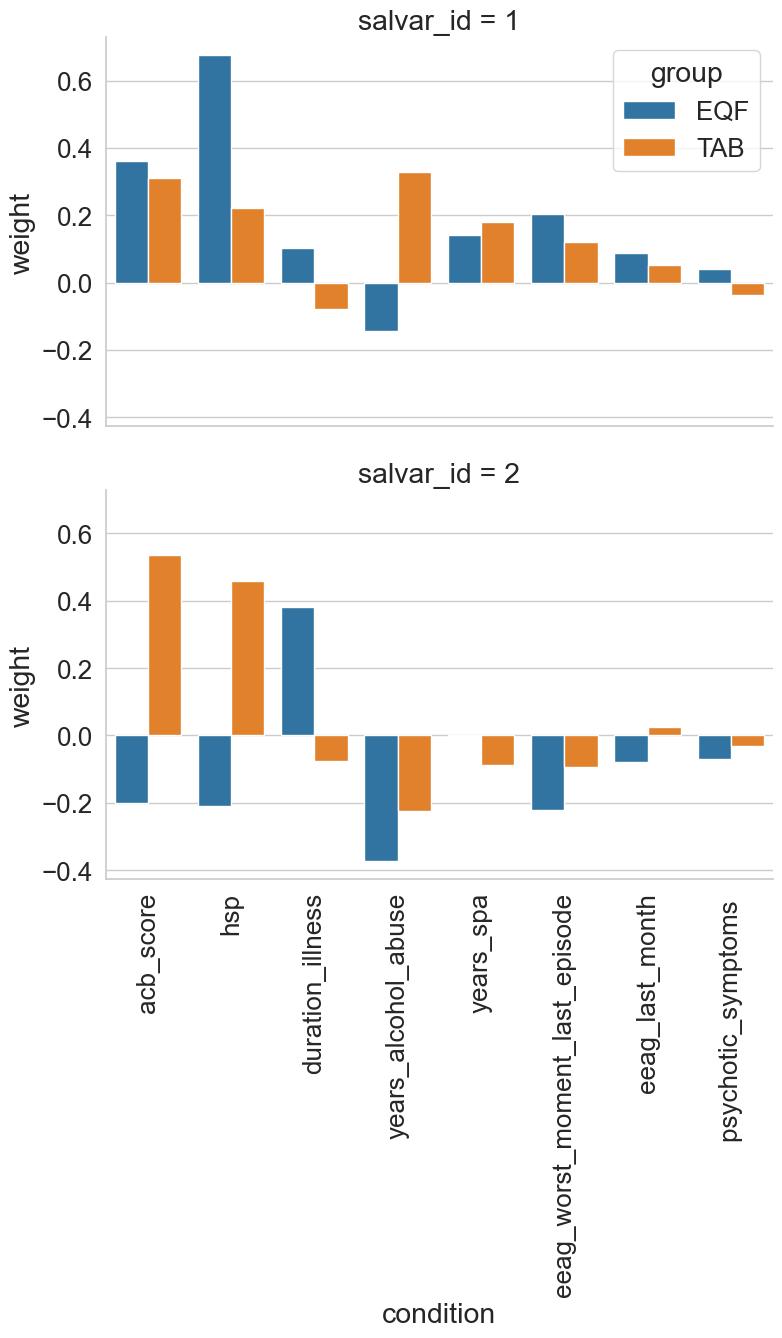

In [60]:
#g = sns.catplot(x="time", y="weight", kind="bar", col="salvar_id", ci=None, aspect=1.2, hue="tratamiento",data=y_loadings_m_TAB)

g = sns.catplot(x="condition", y="weight", hue = "group", kind="bar", row="salvar_id", 
                ci=None, aspect=1.8, data=y_loadings_m, legend_out=False)

#g.map_dataframe(errplot,  [-0.26,1,1.26,2,2.26], "weight", "err")
#g.map_dataframe(errplot,  [0,1,2], "weight", "err")

#plt.title('PLS')
plt.xticks(rotation=90)
#plt.tight_layout()

In [62]:
y_list

['acb_score',
 'hsp',
 'duration_illness',
 'years_alcohol_abuse',
 'years_spa',
 'eeag_worst_moment_last_episode',
 'eeag_last_month',
 'psychotic_symptoms ']

In [59]:
pls.varexp

array([0.21146032, 0.15636213, 0.10549052, 0.09270639, 0.07546987,
       0.05796432, 0.05385826, 0.04727048, 0.04403917, 0.03478616,
       0.0280204 , 0.02469193, 0.02129672, 0.0186827 , 0.01521712,
       0.01268351])

## Gráficos de dispersión

In [ ]:
score_EQF = pd.DataFrame()
score_EQF['subject'] = all_data_sorted_EQF['subject']
score_EQF['grupo'] = all_data_sorted_EQF['grupo']
score_EQF['subject'] = all_data_sorted_EQF['subject']
score_EQF['project'] = all_data_sorted_EQF['project']
score_EQF['treatment'] = all_data_sorted_EQF['treatment']
score_EQF['psc'] = all_data_sorted_EQF['psc'].where(pd.notnull(all_data_sorted_EQF['psc']), -1).astype(int)
score_EQF['Gravedad'] = all_data_sorted_EQF['Gravedad']
score_EQF['x_score_1']=pls_EQF.x_scores[:,0]
score_EQF['y_score_1']=pls_EQF.y_scores[:,0]
score_EQF['x_score_2']=pls_EQF.x_scores[:,1]
score_EQF['y_score_2']=pls_EQF.y_scores[:,1]

score_TAB = pd.DataFrame()
score_TAB['subject'] = all_data_sorted_TAB['subject']
score_TAB['grupo'] = all_data_sorted_TAB['grupo']
score_TAB['subject'] = all_data_sorted_TAB['subject']
score_TAB['project'] = all_data_sorted_TAB['project']
score_TAB['treatment'] = all_data_sorted_TAB['treatment']
score_TAB['psc'] = all_data_sorted_TAB['psc'].where(pd.notnull(all_data_sorted_TAB['psc']), -1).astype(int)
score_TAB['Gravedad'] = all_data_sorted_TAB['Gravedad']
score_TAB['x_score_1']=pls_TAB.x_scores[:,0]
score_TAB['y_score_1']=pls_TAB.y_scores[:,0]
score_TAB['x_score_2']=pls_TAB.x_scores[:,1]
score_TAB['y_score_2']=pls_TAB.y_scores[:,1]

In [ ]:
score_PSI = pd.DataFrame()
score_PSI['subject'] = all_data_sorted_PSI['subject']
score_PSI['grupo'] = all_data_sorted_PSI['grupo']
score_PSI['grupo-p'] = all_data_sorted_PSI['grupo-p']
score_PSI['edad'] = all_data_sorted_PSI['edad']
score_PSI['project'] = all_data_sorted_PSI['project']
score_PSI['treatment'] = all_data_sorted_PSI['treatment']
score_PSI['psc'] = all_data_sorted_PSI['psc'].where(pd.notnull(all_data_sorted_PSI['psc']), -1).astype(int)
score_PSI['Gravedad'] = all_data_sorted_PSI['Gravedad']
score_PSI['x_score_1']=pls_PSI.x_scores[:,0]
score_PSI['y_score_1']=pls_PSI.y_scores[:,0]
score_PSI['x_score_2']=pls_PSI.x_scores[:,1]
score_PSI['y_score_2']=pls_PSI.y_scores[:,1]

In [ ]:
score_PSI

In [ ]:
#color = {0: 'w', 1: 'k', 100: 'r'}
color = {0: 'w', 1: 'k', -1: 'r'}
#color = {'controles':'w','prisma1': 'w','prisma3':'k'}
le = LabelEncoder()
subject_n = pd.factorize(score_TAB.apply(lambda x: 'CTRL' if 'CTRL' in x['subject'] else x['subject'], axis=1))[0]
score_TAB['subject_color'] = le.fit_transform(subject_n)
score_TAB['edge_color'] = score_TAB.apply(lambda x: color[x['psc']], axis=1)
#score_TAB['line_width'] = score_TAB.apply(lambda x: line[x['psc']], axis=1)

lee = LabelEncoder()
subject_n = pd.factorize(score_EQF.apply(lambda x: 'CTRL' if 'CTRL' in x['subject'] else x['subject'], axis=1))[0]
score_EQF['subject_color'] = lee.fit_transform(subject_n)
score_EQF['edge_color'] = score_EQF.apply(lambda x: color[x['psc']], axis=1)
#score_TAB['line_width'] = score_TAB.apply(lambda x: line[x['psc']], axis=1)

In [ ]:
color = {0: 'w', 1: 'k', -1: 'r'}
lep = LabelEncoder()
subject_n = pd.factorize(score_PSI.apply(lambda x: 'CTRL' if 'CTRL' in x['subject'] else x['subject'], axis=1))[0]
score_PSI['subject_color'] = lep.fit_transform(subject_n)
score_PSI['edge_color'] = score_PSI.apply(lambda x: color[x['psc']], axis=1)
#score_TAB['line_width'] = score_TAB.apply(lambda x: line[x['psc']], axis=1)

In [ ]:
sns.set(rc={'figure.figsize':(11,8)})
g=sns.scatterplot(x="x_score_1", y="y_score_1",
                  hue="subject_color", style="project", size='treatment',sizes=[16,64,236],
                  palette='tab20',data=score_EQF,edgecolor=score_EQF["edge_color"],linewidth=1)
current_handles, current_labels = g.get_legend_handles_labels()
selected_handles = current_handles[61:]
selected_labels = current_labels[61:]
plt.legend(selected_handles,selected_labels)
plt.title("X SCORE VS Y SCORE LV 1 EQF")
plt.show()

In [ ]:
# Gráfico variable latente 1 vs variable latente 2
sns.set(rc={'figure.figsize':(11,8)})
        
g=sns.scatterplot(x="x_score_1", y="x_score_2",
                  hue="subject_color", style="project", size='treatment',sizes=[16,128,236],legend=True,
                  palette='tab20',data=score_EQF,edgecolor=score_EQF["edge_color"],linewidth=1)


current_handles, current_labels = g.get_legend_handles_labels()
selected_handles = current_handles[61:]
selected_labels = current_labels[61:]
plt.legend(selected_handles,selected_labels)
plt.title("X SCORE LV1 VS X SCORE LV2 EQF")
plt.show()

In [ ]:
# Gráfico variable latente 1 vs gravedad
score_EQF_na = score_EQF.dropna(subset=['Gravedad'])
g=sns.scatterplot(x="x_score_1", y="Gravedad",
                 hue="subject_color", style="project", size='treatment',sizes=[16,128,236],
                palette='tab20',data=score_EQF_na,edgecolor=score_EQF_na["edge_color"],linewidth=1)
current_handles, current_labels = g.get_legend_handles_labels()
selected_handles = current_handles[60:]
selected_labels = current_labels[60:]
plt.legend(selected_handles,selected_labels)
plt.title("X SCORE LV1 VS Gravedad EQF")
plt.show()

In [ ]:
g=sns.scatterplot(x="x_score_1", y="y_score_1",
                 hue="subject_color", style="project", size='treatment',sizes=[16,64,236],
                palette='tab20',data=score_TAB,edgecolor=score_TAB["edge_color"],linewidth=1)
current_handles, current_labels = g.get_legend_handles_labels()
selected_handles = current_handles[83:]
selected_labels = current_labels[83:]
plt.legend(selected_handles,selected_labels)
plt.title("X SCORE VS Y SCORE LV 1 TAB")
plt.show()

In [ ]:
#sns.set(rc={'figure.figsize':(11,8)})
g= sns.scatterplot(x="x_score_1", y="x_score_2",
                hue="subject_color", style="project", size='treatment',sizes=[16,128,236],legend=True,
                palette='tab20',data=score_TAB,edgecolor=score_TAB["edge_color"],linewidth=1)

current_handles, current_labels = g.get_legend_handles_labels()
selected_handles = current_handles[83:]
selected_labels = current_labels[83:]
plt.legend(selected_handles,selected_labels)
plt.title("X SCORE LV1 VS X SCORE LV2 TAB")
plt.show()


In [ ]:
score_TAB_na = score_TAB.dropna(subset=['Gravedad'])
markers = {0.0: "X", 1.0: "o",2.0:"s"}
g=sns.scatterplot(x="x_score_1", y="Gravedad",
                  hue="subject_color", style="project", size='treatment',sizes=[16,128,236],
                  palette='tab20',data=score_TAB,edgecolor=score_TAB["edge_color"],linewidth=1)
current_handles, current_labels = g.get_legend_handles_labels()
selected_handles = current_handles[83:]
selected_labels = current_labels[83:]
plt.legend(selected_handles,selected_labels)
plt.title("X SCORE LV1 VS Gravedad TAB")
plt.show()

In [ ]:
sns.set(rc={'figure.figsize':(11,8)})
g=sns.scatterplot(x="x_score_1", y="y_score_1",
                  hue="subject_color", style="project", size='treatment',sizes=[16,64,236],
                  palette='tab20',data=score_PSI,edgecolor=score_PSI["edge_color"],linewidth=1)
current_handles, current_labels = g.get_legend_handles_labels()
selected_handles = current_handles[147:]
selected_labels = current_labels[147:]
plt.legend(selected_handles,selected_labels)
plt.title("X SCORE VS Y SCORE LV 1 EQF+TAB")
plt.show()

In [ ]:
sns.set(rc={'figure.figsize':(11,8)})
g=sns.scatterplot(x="x_score_1", y="y_score_1",
                  hue="grupo", style="project", size='treatment',sizes=[16,64,236],
                  palette='tab20',data=score_PSI,edgecolor=score_PSI["edge_color"],linewidth=1)
#current_handles, current_labels = g.get_legend_handles_labels()
#selected_handles = current_handles[146:]
#selected_labels = current_labels[146:]
#plt.legend(selected_handles,selected_labels)
plt.title("X SCORE VS Y SCORE LV 1 EQF+TAB")
plt.show()

In [ ]:
sns.set(rc={'figure.figsize':(11,8)})
g=sns.scatterplot(x="x_score_1", y="x_score_2",
                 hue="subject_color", style="project", size='treatment',sizes=[16,128,236],legend=True,
                palette='tab20',data=score_PSI,edgecolor=score_PSI["edge_color"],linewidth=1)
current_handles, current_labels = g.get_legend_handles_labels()
selected_handles = current_handles[147:]
selected_labels = current_labels[147:]
plt.legend(selected_handles,selected_labels)
plt.title("X SCORE LV1 VS X SCORE LV2 EQF+TAB")
plt.show()

In [ ]:
sizes = {'CTR': 128, 'EQF':236 ,'TAB':236}
score_PSI['grupo-size'] = score_PSI.apply(lambda x: sizes[x['grupo']], axis=1)
#score_TAB['line_width'] = score_TAB.apply(lambda x: line[x['psc']], axis=1)
score_PSI

In [ ]:
g=sns.scatterplot(x="x_score_1", y="x_score_2", size=score_PSI['grupo-size'],
                  hue="grupo", style="project",legend=True,
                  data=score_PSI,edgecolor=score_PSI["edge_color"],linewidth=1)

current_handles, current_labels = g.get_legend_handles_labels()
selected_handles = current_handles[0:4]
selected_handles.extend(current_handles[7:11])
selected_labels = current_labels[0:4]
selected_labels.extend(current_labels[7:11])
plt.legend(selected_handles,selected_labels)
plt.title("X SCORE LV1 VS X SCORE LV2 EQF+TAB")
plt.show()

In [ ]:
score_PSI_na = score_PSI.dropna(subset=['Gravedad'])
#g=sns.scatterplot(x="x_score_1", y="Gravedad",
#                 hue="subject_color", style="project", size='treatment',sizes=[16,128,236],
#                palette='tab20',data=score_PSI_na,edgecolor=score_PSI_na["edge_color"],linewidth=1)
g=sns.scatterplot(x="x_score_1", y="Gravedad", size=score_PSI['grupo-size'],
                  hue="grupo", style="project",legend=True,
                  data=score_PSI,edgecolor=score_PSI["edge_color"],linewidth=1)
current_handles, current_labels = g.get_legend_handles_labels()
selected_handles = current_handles[0:4]
selected_handles.extend(current_handles[7:11])
selected_labels = current_labels[0:4]
selected_labels.extend(current_labels[7:11])
plt.legend(selected_handles,selected_labels)
plt.title("X SCORE LV1 VS Gravedad EQF+TAB")
plt.show()

In [ ]:
sns.set(rc={'figure.figsize':(11,8)})
g=sns.scatterplot(x="x_score_1", y="psc", size=score_PSI['grupo-size'],
                  hue="grupo", style="project",legend=True,
                  data=score_PSI,linewidth=1)
current_handles, current_labels = g.get_legend_handles_labels()
selected_handles = current_handles[0:4]
selected_handles.extend(current_handles[7:11])
selected_labels = current_labels[0:4]
selected_labels.extend(current_labels[7:11])
plt.legend(selected_handles,selected_labels)
plt.title("X SCORE LV1 VS Psicosis EQF+TAB")
plt.show()

In [ ]:
sns.set(rc={'figure.figsize':(11,8)})
g=sns.scatterplot(x="x_score_1", y="edad", size=score_PSI['grupo-size'],
                  hue="grupo", style="project",legend=True,
                  data=score_PSI,edgecolor=score_PSI["edge_color"],linewidth=1)
current_handles, current_labels = g.get_legend_handles_labels()
selected_handles = current_handles[0:4]
selected_handles.extend(current_handles[7:11])
selected_labels = current_labels[0:4]
selected_labels.extend(current_labels[7:11])
plt.legend(selected_handles,selected_labels)
plt.title("X SCORE LV1 VS Edad EQF+TAB")
plt.show()

## X Weights

In [ ]:
yeo_pal = {'Vis': (0.47058823529411764, 0.07058823529411765, 0.5254901960784314),
 'SomMot': (0.27450980392156865, 0.5098039215686274, 0.7058823529411765),
 'DorsAttn': (0.0, 0.4627450980392157, 0.054901960784313725),
 'SalVentAttn': (0.7686274509803922, 0.22745098039215686, 0.9803921568627451),
 'Limbic': (0.8627450980392157, 0.9725490196078431, 0.6431372549019608),
 'Cont': (0.9019607843137255, 0.5803921568627451, 0.13333333333333333),
 'Default': (0.803921568627451, 0.24313725490196078, 0.3058823529411765),
 'None': (0.7, 0.7, 0.7, 0.5),
 'TempPar': 'blue'}

In [ ]:
EQF_data = all_data_sorted_EQF.iloc[:,3:-6] # Selecciona sólo los datos de volúmenes 
networks7_order = pd.read_csv('Schaefer2018_400Parcels_17Networks_order.txt',header=None,delimiter=' ')

sch_x_sch_weights_EQF = pls_EQF.bootres.x_weights_normed[50:,0] # Selección variables corticales
df_x_weights_sch_EQF = pd.DataFrame(sch_x_sch_weights_EQF, columns=["weight"])
df_x_weights_sch_EQF.index = networks7_order[1]
df_x_weights_sch_EQF["network"] = df_x_weights_sch_EQF.index.str.split('_').str.get(2)

df_x_weights_sch_EQF.loc[df_x_weights_sch_EQF.network.str.contains('Vis'), 'network'] = 'Vis'
df_x_weights_sch_EQF.loc[df_x_weights_sch_EQF.network.str.contains('SomMot'), 'network'] = 'SomMot'
df_x_weights_sch_EQF.loc[df_x_weights_sch_EQF.network.str.contains('DorsAttn'), 'network'] = 'DorsAttn'
df_x_weights_sch_EQF.loc[df_x_weights_sch_EQF.network.str.contains('SalVentAttn'), 'network'] = 'SalVentAttn'
df_x_weights_sch_EQF.loc[df_x_weights_sch_EQF.network.str.contains('Limbic'), 'network'] = 'Limbic'
df_x_weights_sch_EQF.loc[df_x_weights_sch_EQF.network.str.contains('Cont'), 'network'] = 'Cont'
df_x_weights_sch_EQF.loc[df_x_weights_sch_EQF.network.str.contains('Default'), 'network'] = 'Default'

th = 3 
df_x_weights_sch_EQF["weight_th"] =  (abs(df_x_weights_sch_EQF["weight"])>= th)*1


fig, axes = plt.subplots(1, 2, sharex=False, figsize=(15,5))
fig.suptitle('X weights cortical volumes EQF')

order_g = df_x_weights_sch_EQF.groupby(["network"]).mean().sort_values(by='weight').index
g = sns.barplot(x="network", y="weight", ax=axes[0], palette=yeo_pal,
                order=order_g, data=df_x_weights_sch_EQF)

g.set(ylabel='weight intensity')
g.tick_params(labelrotation=60)
order_h = df_x_weights_sch_EQF.groupby(["network"]).sum().sort_values(by='weight_th').index
h = sns.barplot(x="network", y="weight_th", ci=None, ax=axes[1], estimator=sum, palette=yeo_pal,
                order=order_h, data=df_x_weights_sch_EQF)
h.set(ylabel='weight th count')
h.tick_params(labelrotation=60)


In [ ]:
sch_x_v_weights_EQF = pls_EQF.bootres.x_weights_normed[:50,0]
df_x_weights_v_EQF = pd.DataFrame(sch_x_v_weights_EQF, columns=["weight"])
df_x_weights_v_EQF['volume'] = list(EQF_data.iloc[:,:50].columns)
#df_x_weights_v_EQF['category'] = ['Lateral-Ventricle','Lateral-Ventricle','Cerebellum','Cerebellum','Thalamus','Caudate','Putamen','Pallidum','3rd-Ventricle','4th-Ventricle','Brain-Stem','Hippocampus','Amygdala','CSF','Accumbens-area','VentralDC','vessel','choroid-plexus','Lateral-Ventricle','Lateral-Ventricle','Cerebellum','Cerebellum','Thalamus','Caudate','Putamen','Pallidum','Hippocampus','Amygdala','Accumbens-area','VentralDC','vessel','choroid-plexus','Optic-Chiasm','CC','CC','CC','CC','CC']
th = 3
df_x_weights_v_EQF["weight_th"] =  (abs(df_x_weights_v_EQF["weight"])>= th)*1

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
fig.suptitle('X weights subcortical volumes EQF')

#g=sns.barplot(x="category", y="weight", ci=None, ax=axes[0],
#            data=df_x_weights_v_EQF)
g=sns.barplot(x="volume", y="weight", ci=None, ax=axes[0],
              data=df_x_weights_v_EQF)
g.set(ylabel='weight intensity')
g.tick_params(labelrotation=60)
h = sns.barplot(x="volume", y="weight_th", ci=None, ax=axes[1], estimator=sum,
            data=df_x_weights_v_EQF)
h.set(ylabel='weight th count')
h.tick_params(labelrotation=60)

In [ ]:
schaefer_image = 'Schaefer2018_400_17N_MNI152_2mm.nii'
sch_masker=input_data.NiftiLabelsMasker(schaefer_image)
sch_values=sch_masker.fit()
th = 3
values_brain_weight_vol = sch_masker.inverse_transform(sch_x_sch_weights_EQF[np.newaxis,:])
plotting.view_img(values_brain_weight_vol, threshold=th, title='X weights EQF', symmetric_cmap=False)

## TAB

In [ ]:
TAB_data = all_data_sorted_TAB.iloc[:,3:-6]
networks7_order = pd.read_csv('Schaefer2018_400Parcels_17Networks_order.txt',header=None,delimiter='\t')
sch_x_sch_weights_TAB = pls_TAB.bootres.x_weights_normed[50:,0]
df_x_weights_sch_TAB = pd.DataFrame(sch_x_sch_weights_TAB, columns=["weight"])
df_x_weights_sch_TAB.index = networks7_order[1]
df_x_weights_sch_TAB["network"] = df_x_weights_sch_TAB.index.str.split('_').str.get(2)

df_x_weights_sch_TAB.loc[df_x_weights_sch_TAB.network.str.contains('Vis'), 'network'] = 'Vis'
df_x_weights_sch_TAB.loc[df_x_weights_sch_TAB.network.str.contains('SomMot'), 'network'] = 'SomMot'
df_x_weights_sch_TAB.loc[df_x_weights_sch_TAB.network.str.contains('DorsAttn'), 'network'] = 'DorsAttn'
df_x_weights_sch_TAB.loc[df_x_weights_sch_TAB.network.str.contains('SalVentAttn'), 'network'] = 'SalVentAttn'
df_x_weights_sch_TAB.loc[df_x_weights_sch_TAB.network.str.contains('Limbic'), 'network'] = 'Limbic'
df_x_weights_sch_TAB.loc[df_x_weights_sch_TAB.network.str.contains('Cont'), 'network'] = 'Cont'
df_x_weights_sch_TAB.loc[df_x_weights_sch_TAB.network.str.contains('Default'), 'network'] = 'Default'

th = 3
df_x_weights_sch_TAB["weight_th"] =  (abs(df_x_weights_sch_TAB["weight"])>= th)*1


fig, axes = plt.subplots(1, 2, sharex=False, figsize=(15,5))
fig.suptitle('X weights cortical volumes TAB')

order_g = df_x_weights_sch_TAB.groupby(["network"]).mean().sort_values(by='weight').index
g = sns.barplot(x="network", y="weight", ax=axes[0], order= order_g,palette=yeo_pal,
            data=df_x_weights_sch_TAB)
g.set(ylabel='weight intensity')
g.tick_params(labelrotation=60)
order_h = df_x_weights_sch_TAB.groupby(["network"]).sum().sort_values(by='weight_th').index
h = sns.barplot(x="network", y="weight_th", ci=None, ax=axes[1], estimator=sum,order= order_h,palette=yeo_pal,
            data=df_x_weights_sch_TAB)
h.set(ylabel='weight th count')
h.tick_params(labelrotation=60)

In [ ]:
sch_x_v_weights_TAB = pls_TAB.bootres.x_weights_normed[:50,0]
df_x_weights_v_TAB = pd.DataFrame(sch_x_v_weights_TAB, columns=["weight"])
df_x_weights_v_TAB['volume'] = list(TAB_data.iloc[:,:50].columns)
#df_x_weights_v_TAB['category'] = ['Lateral-Ventricle','Lateral-Ventricle','Cerebellum','Cerebellum','Thalamus','Caudate','Putamen','Pallidum','3rd-Ventricle','4th-Ventricle','Brain-Stem','Hippocampus','Amygdala','CSF','Accumbens-area','VentralDC','vessel','choroid-plexus','Lateral-Ventricle','Lateral-Ventricle','Cerebellum','Cerebellum','Thalamus','Caudate','Putamen','Pallidum','Hippocampus','Amygdala','Accumbens-area','VentralDC','vessel','choroid-plexus','Optic-Chiasm','CC','CC','CC','CC','CC']
th = 3
df_x_weights_v_TAB["weight_th"] =  (abs(df_x_weights_v_TAB["weight"])>= th)*1

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
fig.suptitle('X weights subcortical volumes TAB')

g=sns.barplot(x="volume", y="weight", ci=None, ax=axes[0],
            data=df_x_weights_v_TAB)
g.set(ylabel='weight intensity')
g.tick_params(labelrotation=60)
h = sns.barplot(x="volume", y="weight_th", ci=None, ax=axes[1], estimator=sum,
            data=df_x_weights_v_TAB)
h.set(ylabel='weight th count')
h.tick_params(labelrotation=60)

In [ ]:
schaefer_image = 'Schaefer2018_400_17N_MNI152_2mm.nii'
sch_masker=input_data.NiftiLabelsMasker(schaefer_image)
sch_values=sch_masker.fit()
#th = max(sch_x_sch_weights_TAB)*0.6
th=3
values_brain_weight_vol = sch_masker.inverse_transform(sch_x_sch_weights_TAB[np.newaxis,:])
plotting.view_img(values_brain_weight_vol, threshold=th, title='X weights TAB', symmetric_cmap=False)

EQF+TAB

In [ ]:
PSI_data = all_data_sorted_PSI.iloc[:,3:-7]
networks7_order = pd.read_csv('Schaefer2018_400Parcels_17Networks_order.txt',header=None,delimiter='\t')
sch_x_sch_weights_PSI = pls_PSI.bootres.x_weights_normed[50:,0]
df_x_weights_sch_PSI = pd.DataFrame(sch_x_sch_weights_PSI, columns=["weight"])
df_x_weights_sch_PSI.index = networks7_order[1]
df_x_weights_sch_PSI["network"] = df_x_weights_sch_PSI.index.str.split('_').str.get(2)

df_x_weights_sch_PSI.loc[df_x_weights_sch_PSI.network.str.contains('Vis'), 'network'] = 'Vis'
df_x_weights_sch_PSI.loc[df_x_weights_sch_PSI.network.str.contains('SomMot'), 'network'] = 'SomMot'
df_x_weights_sch_PSI.loc[df_x_weights_sch_PSI.network.str.contains('DorsAttn'), 'network'] = 'DorsAttn'
df_x_weights_sch_PSI.loc[df_x_weights_sch_PSI.network.str.contains('SalVentAttn'), 'network'] = 'SalVentAttn'
df_x_weights_sch_PSI.loc[df_x_weights_sch_PSI.network.str.contains('Limbic'), 'network'] = 'Limbic'
df_x_weights_sch_PSI.loc[df_x_weights_sch_PSI.network.str.contains('Cont'), 'network'] = 'Cont'
df_x_weights_sch_PSI.loc[df_x_weights_sch_PSI.network.str.contains('Default'), 'network'] = 'Default'

th = 3
df_x_weights_sch_PSI["weight_th"] =  (abs(df_x_weights_sch_PSI["weight"])>= th)*1


fig, axes = plt.subplots(1, 2, sharex=False, figsize=(15,5))
fig.suptitle('X weights cortical volumes EQF+TAB')

order_g = df_x_weights_sch_PSI.groupby(["network"]).mean().sort_values(by='weight').index
g = sns.barplot(x="network", y="weight", ax=axes[0], order= order_g,palette=yeo_pal,
            data=df_x_weights_sch_PSI)
g.set(ylabel='weight intensity')
g.tick_params(labelrotation=60)
order_h = df_x_weights_sch_PSI.groupby(["network"]).sum().sort_values(by='weight_th').index
h = sns.barplot(x="network", y="weight_th", ci=None, ax=axes[1], estimator=sum,order= order_h,palette=yeo_pal,
            data=df_x_weights_sch_PSI)
h.set(ylabel='weight th count')
h.tick_params(labelrotation=60)
# Incluir ROIs en una tabla

In [ ]:
df_x_weights_sch_PSI = df_x_weights_sch_PSI[df_x_weights_sch_PSI['weight_th']>0]
df_x_weights_sch_PSI.reset_index(inplace=True)
df_x_weights_sch_PSI.columns = ['structure', 'weight','network','weight_th']
y = df_x_weights_sch_PSI[['structure','network']]
y = y.sort_values(by=['network'])
y

In [ ]:
sch_x_v_weights_PSI = pls_PSI.bootres.x_weights_normed[:49,0]
df_x_weights_v_PSI = pd.DataFrame(sch_x_v_weights_PSI, columns=["weight"])
df_x_weights_v_PSI['volume'] = list(PSI_data.iloc[:,:49].columns)
#df_x_weights_v_TAB['category'] = ['Lateral-Ventricle','Lateral-Ventricle','Cerebellum','Cerebellum','Thalamus','Caudate','Putamen','Pallidum','3rd-Ventricle','4th-Ventricle','Brain-Stem','Hippocampus','Amygdala','CSF','Accumbens-area','VentralDC','vessel','choroid-plexus','Lateral-Ventricle','Lateral-Ventricle','Cerebellum','Cerebellum','Thalamus','Caudate','Putamen','Pallidum','Hippocampus','Amygdala','Accumbens-area','VentralDC','vessel','choroid-plexus','Optic-Chiasm','CC','CC','CC','CC','CC']
th = 3
df_x_weights_v_PSI["weight_th"] =  (abs(df_x_weights_v_PSI["weight"])>= th)*1

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
fig.suptitle('X weights subcortical volumes EQF+TAB')

g=sns.barplot(x="volume", y="weight", ci=None, ax=axes[0],
            data=df_x_weights_v_PSI)
g.set(ylabel='weight intensity')
g.tick_params(labelrotation=60)
h = sns.barplot(x="volume", y="weight_th", ci=None, ax=axes[1], estimator=sum,
            data=df_x_weights_v_PSI)
h.set(ylabel='weight th count')
h.tick_params(labelrotation=60)

In [ ]:
schaefer_image = 'Schaefer2018_400_17N_MNI152_2mm.nii' 
sch_masker=input_data.NiftiLabelsMasker(schaefer_image)
sch_values=sch_masker.fit()
th=3
values_brain_weight_vol = sch_masker.inverse_transform(sch_x_sch_weights_PSI[np.newaxis,:])
plotting.view_img(values_brain_weight_vol, threshold=th, title='X weights EQF+TAB', symmetric_cmap=False)

In [ ]:
# Ploting stat map
#(barrido axial), que se puedan superponer los bordes de las redes (plot contours)
schaefer_image = 'Schaefer2018_400_17N_MNI152_2mm.nii'
display = plotting.plot_stat_map(values_brain_weight_vol, display_mode='mosaic', cut_coords=(3,3,3), title='X weights EQF+TAB', 
                       threshold=th, dim = 0, symmetric_cbar=False, black_bg=True,
                       colorbar=True)
display.add_contours(schaefer_image, cmap='Paired')


In [ ]:
schaefer_image = 'Schaefer2018_400_17N_MNI152_2mm.nii'
sch_masker=input_data.NiftiLabelsMasker(schaefer_image)
sch_values=sch_masker.fit()
plotting.plot_roi(schaefer_image, view_type='contours', title="", cmap='Paired')
plotting.show()